In [257]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import astropy.units as u
import sys 
import os
sys.path.append("../src")
from regression import FrequentistRegression
from scipy.optimize import curve_fit
params = {
         'axes.labelsize': 20,
         'axes.titlesize': 20,
         'ytick.labelsize' :20,
         'xtick.labelsize' :20,
         'legend.fontsize': 15,
         'xtick.major.size': 5,
         'xtick.minor.size': 4,
         'xtick.major.width': 3,
         'xtick.minor.width': 2,
         'ytick.major.size': 5,
         'ytick.minor.size': 4,
         'ytick.major.width': 3,
         'ytick.minor.width': 2,
         'ytick.color': "k",
         'xtick.color': "k",
         'axes.labelcolor': "k",
         'ytick.labelcolor' : "k",
         'xtick.labelcolor' : "k",
         'font.size': 15
         }
plt.rcParams.update(params)
plt.style.use('science')

figure_folder = 'C://Users//Admin//Desktop//lab_optique//data//optique_non_lineaire'

## Théorie: 

Un laser utilise le principe d'inversion de population pour produire un faisceau cohérent de photons (une seule longueur d'onde, phase uniforme en temps et en espace). 

On veut faire différentes mesures spécifiques dans cette expériences: 
1) La puissance du laser en fonction du courant $I$ dans la diode
2) Déterminer la polarisation de l'émission laser
3) Ajouter cristal KTP et une lame demi-onde pour obtenir une émission pour la deuxième harmonique (doublage de fréquence) en fonction de l'angle de la lame demi-onde $\theta$ et de l'orientation du cristal (prendre des mesures pour plusieurs angles et orientations)
4) Déterminez (ou mesurer ?) l'intensité à 532 nm en fonction de l'orientation du cristal et de la lame demi-onde (mesurer pour différentes orientations et angles)
5) 
6) 
7) Expérience additionnelle: Polarisation après l'ajout du cristal ?

### Questions: 
Are we supposed to measure the polarization ? How ? 



## Semaine 1: 
Les différentes expériences de cette semaine incluent: 
1) Mesures de la loi de Malus
2) Mesures du spectre $I$ vs $\lambda$ du laser autour de 1064 nm (avec un courant dans la pompe $I_p$ constant)
3) Mesures du rapport $\frac{I_{max}(1064 \text{nm})}{I_{max}(\text{808 nm})}$ en fonction du courant dans la pompe. 


#### Loi de Malus. 

La loi de Malus relie l'intensité d'une onde polarisée linéairement d'intensité $I_0 = \sqrt{E_0}$ à l'intensité $I$ de l'onde après son passage dans un polariseur linéaire parfait orienté selon un angle $\theta - \phi$ par rapport au plan de propagation de l'onde. Mathématiquement, on a 
$$
I(\theta) = I_0 \cos^2(\theta - \phi) \, .
$$
Durant l'expérience, on mesurait seulement $\theta$, l'angle de polarisation du polariseur par rapport à la verticale. Cependant, la loi de Malus s'applique pour **l'angle de polarisation entre le polariseur et la direction de polarisation du laser** et on doit introduire le déphasage $\phi$. Il nous faut donc ajuster deux paramètres, $I_0$ et $\phi$. 

Parlons d'incertitudes avant de commencer le code. On utilise la plus demie-mesure de la plus petite graduation de notre instrument de mesure pour l'angle, donc $\sigma_\theta \sim 2$ degrés. Pour I, on prend une vingtaine de mesures au même angle en réinitialisant le set up expérimental à chaque fois et on mesure l'écart type de cet ensemble de mesures. 

Petit calcul pour "rendre la loi de Malus linéaire": 
$$
\begin{align}
\cos^2(\theta - \phi)&=\frac{1 + \cos\left(2(\theta - \phi)\right)}{2}
\\
&=\frac{1}{2} + \frac{1}{2}\cos(2(\theta - \phi))
\\
&=\frac{1}{2} + \frac{1}{2}\left[\cos(2\theta)\cos(2\phi) + \sin(2 \theta)\sin(2 \phi) \right]
\\
&= \frac{1}{2} + \beta_1\cos(2\theta) +\beta_2 \sin(2 \theta) 
\end{align}
$$
On peut donc réécrire la loi de Malus de manière linéaire comme 
$$
I(\theta) = \beta_0 + \beta_1 \cos(2 \theta) + \beta_2 \sin(2\theta)
$$
où les $\beta_i$ sont les paramètres à ajuster avec 
$$
\begin{align}
\beta_0 = \frac{I_0}{2} &\rightarrow I_0 = 2 \beta_0
\\
\beta_1 = \frac{I_0}{2} \cos(2\phi) &\rightarrow \phi = \frac{1}{2}\arccos(\beta_1/\beta_0)
\\
\beta_2 = \frac{I_0}{2}\sin(2\phi) &\rightarrow \phi = -\frac{1}{2}\arcsin(\beta_2/\beta_0)
\\
\frac{\beta_2}{\beta_1}= \tan(2 \phi) &\rightarrow \phi = \frac{1}{2}\arctan(\beta_2/\beta_1)
\end{align}
$$

À l'issue de la régression linéaire, on a des incertitudes sur les paramètres ajustées $\beta_i$. On utilise donc la formule de propagation des incertitudes pour retrouver les incertitudes sur les variables physiques $I_0$ et $\phi$.
$$
\begin{align}
I_0 &= 2 \beta_0 \\
\sigma_{I_0} &=|\frac{\partial I_0}{\partial \beta_0}\sigma_{\beta_0}|=2 \sigma_{\beta_0}\\
\phi &= \frac{1}{2} \arctan\left( \frac{\beta_2}{\beta_1}\right)
\\
\frac{\partial \phi}{\partial \beta_2} &= \frac{\beta_1}{2(\beta_1^2 + \beta_2^2)} 
\\
\frac{\partial \phi}{\partial \beta_1} &= -\frac{\beta_2}{2(\beta_1^2 + \beta_2^2)} 
\\
\sigma_\phi &= \sqrt{\left( \frac{\partial \phi}{\partial \beta_1}\right)^2\sigma_{\beta_1}^2 + \left( \frac{\partial \phi}{\partial \beta_2}\right)^2\sigma_{\beta_2}^2} 
\\
&= \sqrt{\left(\frac{\beta_1}{2(\beta_1^2 + \beta_2^2)} \right)^2 \sigma_{\beta_1}^2 + \left(\frac{\beta_2}{2(\beta_1^2 + \beta_2^2)} \right)^2 \sigma_{\beta_2}^2}
\\
&= \frac{1}{2(\beta_1^2 + \beta_2^2)}\sqrt{\beta_1^2\sigma_{\beta_1}^2 + \beta_2 \sigma_{\beta_2}^2}
\end{align}
$$

Dernière équation ici. On va également avoir une incertitude sur l'intensité prédite par la loi de Malus en propageant les incertitudes une dernière fois. 
$$
\begin{align}
\sigma_{I} &= \sqrt{\left( \frac{\partial I}{\partial I_0}\right)^2\sigma_{I_0}^2 + \left( \frac{\partial I}{\partial \phi}\right)^2\sigma_{\phi}^2}
\\
&= \sqrt{\cos^2(\theta-\phi)\sigma_{I_0}^2  + 4 I_0^2\sin^2(\theta-\phi)\cos^2(\theta-\phi)\sigma_{\phi}^2}
\end{align}
$$

Note: De manière équivalente, on peut faire passer les valeurs optimales $(I_{0}, \phi)$ perturbées par les déviations standards $\sigma_{I_{0}}$ et $\sigma_{\phi}$ puis les faire passer dans la loi de Malus afin de propager les incertitudes. La seconde méthode implique moins de maths (mais c'est une belle dérivation!).


In [252]:
def malus_law(theta, I0, phi):
    return I0 * np.cos(theta - phi) ** 2

def fit_params_to_phys_params(param1, param2, param3): 
    return np.array([2 * param1, 0.5 * np.arctan(param3 / param2)])

def std_params_to_std_physical(params, stds): 
    """
    Must take as input the combination (value, std)

    Args:
        pair1 (Tuple): _description_
        pair2 (Tuple): _description_
        pair3 (Tuple): _description_
    """
    sigma_intensity_fitted = 2 * stds[0]

    beta1, beta2 = params[1:]
    sigma_beta1 = stds[1]
    sigma_beta2 = stds[2]
    sigma_phi_fitted = 1 / (beta1 ** 2 + beta2 ** 2) * np.sqrt(beta1 ** 2 * sigma_beta1 ** 2 + beta2 ** 2 * sigma_beta2 ** 2)
    return np.array([sigma_intensity_fitted, sigma_phi_fitted])

def std_malus(theta, phys_fitted, phys_std):
    I0, phi = phys_fitted
    std_intensity, std_phi = phys_std
    print(phi)
    print(std_intensity)
    print(std_phi)
    return np.sqrt(np.cos(theta - phi) ** 2 * std_intensity ** 2  + (2 * I0 * np.sin(theta - phi) * np.cos(theta - phi)) ** 2 * std_phi ** 2)

In [268]:
# Importation des valeurs expérimentales mesurées 
theta = np.arange(20, 361, 20) * u.degree.to(u.radian)  # rad
sigma_theta = 2 * u.degree.to(u.radian) # rad
intensity_20 = np.array([0.00926, 0.00910, 0.007, 0.0073, 0.0072,0.00902, 0.00813, 0.00910, 0.00612, 0.00625, 0.00618, 0.0064]) # series of measurements at theta=20 radians
intensity = np.array([intensity_20.mean(), 0.01000, 0.00842, 0.00527, 0.00186, 0.00023, 0.00049, 0.00275, 0.0053, 0.00835, 0.00920, 0.00770, 0.00520, 0.00200, 0.0002, 0.00049, 0.0026, 0.00590]) # mA
sigma_intensity = intensity_20.std(ddof = 1)

# Régression linéaire (voir code dans src/regression.py)
Regression = FrequentistRegression(
    degree = 1,
    sigma_noise = sigma_intensity
)

# Créer la 'design matrix' de régression
Regression.design_matrix = np.column_stack([np.ones_like(theta),  np.cos(2 * theta), np.sin(2 * theta)])

# Calcul des paramètres beta_i optimaux
params_fitted, std_fitted = Regression.fit(
    obs = intensity, 
    x = None, 
    ridge_reg = 1e-9, 
    fit_intercept = True
)

# Conversion des paramètres de régression ajustées aux paramèteres physiques d'intérêt (ici, l'intensité initiale du faisceau et le déphasage)
phys_fitted = fit_params_to_phys_params(*params_fitted) 
phys_std = std_params_to_std_physical(params = params_fitted, stds = std_fitted)# incertitude sur paramètre physique
intensity_fitted, phi_fitted = phys_fitted
intensity_pred = malus_law(theta, *phys_fitted) # intensity predicted by adjusting our physical model on data 
norm_residuals =  (intensity - intensity_pred) / sigma_intensity 
chi2 = np.sum(norm_residuals ** 2)


(18, 3)
(3, 3)


0.6731396642181613
0.000596802365907908
0.09120421688296829


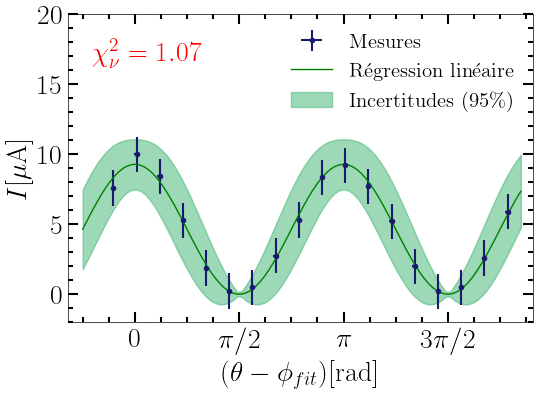

In [269]:
from matplotlib.ticker import MultipleLocator
# Première figure: Intensité versus angle 
fig, axs = plt.subplots(1, 1, figsize = (6, 4))
ax = axs

# Afficher mesures avec erreurs
x = theta - phi_fitted # tableau de valeurs axe des x
ax.errorbar(x = x, 
            y = intensity * 1e3, 
            xerr = sigma_theta, 
            yerr = sigma_intensity * 1e3, 
            fmt = '.', 
            elinewidth=1.5, 
            label = 'Mesures', 
            color = 'midnightblue'
            )

# Afficher prédiction du model 
x_range = np.array([-np.pi / 4, 2 * np.pi])
x_fit =  np.linspace(x_range.min(), x_range.max()-phi_fitted + 0.2, 100)
intensity_fitted = malus_law(x_fit + phi_fitted, *phys_fitted)
ax.plot(x_fit, intensity_fitted * 1e3, "green", label = 'Régression linéaire')

# Afficher incertitudes sur la régression linéaire
# phys_min = phys_fitted - 1 * phys_std
# phys_max = phys_fitted + 1 * phys_std
# intensity_min = malus_law(x_fit + phi_fitted, *phys_min)
# intensity_max = malus_law(x_fit + phi_fitted, *phys_max)
std_intensity = std_malus(theta = x_fit + phi_fitted, phys_fitted = phys_fitted, phys_std = phys_std) 
k = 3
ax.fill_between(
    x = x_fit, 
    y1 = (intensity_fitted - k * std_intensity) * 1e3, 
    y2 = (intensity_fitted + k * std_intensity) * 1e3,
    color = 'mediumseagreen', 
    alpha = 0.5, 
    label = r'Incertitudes ($95\%$)'
    )

# Rendre la figure plus jolie :) 
ax.set(xlabel = r"$(\theta-\phi_{fit})$[rad]", ylabel = r"$I$[$\mu$A]", xlim = [-1, 6.], ylim = [-2, 20])
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.annotate(r"$\chi^2_{\nu} = %.2f$"%chi2, xy = (0.05, 0.85), xycoords = 'axes fraction', color = 'r', fontsize = 20)

x_ticks = np.arange(0, 5, np.pi/2)
x_tick_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$"]
ax.xaxis.set_ticks(x_ticks)
ax.xaxis.set_ticklabels(x_tick_labels)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.savefig(os.path.join(figure_folder, 'figure_malus.pdf'), bbox_inches = 'tight')
# maj_ticks = 

(array([ 1.,  3., 10.,  3.,  1.]),
 array([-0.59519298, -0.36199265, -0.12879232,  0.10440801,  0.33760834,
         0.57080867]),
 <BarContainer object of 5 artists>)

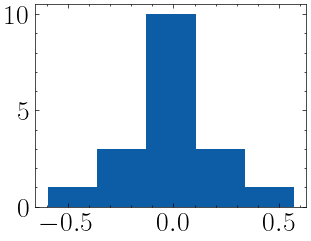

In [267]:
plt.hist(norm_residuals, bins = 5)

### Calcul de la largeur spectrale du laser 

On veut maintenant faire une régression linéaire sur une Gaussienne. L'astuce ici est de faire la régression dans l'espace logarithmique. L'intensité (en termes de comptes) est ici définie comme 
$$
\begin{align}
I(\lambda) = I_{0} \exp\left(\frac{(\lambda-\lambda_0)^2}{2w^2}\right)
\end{align}
$$
où $\lambda_{0}$ est la moyenne de la Gaussienne (là où le pic d'émission du laser est censé se situer)

On peut maintenant appliquer le log
$$
\begin{align}
\ln I (\lambda)&= \frac{(\lambda - \lambda_0)^2}{2w^2} - \ln(I_0)
\\
&= \frac{1}{2w^2} \left(\lambda^2 - 2 \lambda \lambda_{0} +\lambda_{0}^2 - \ln(I_0)\right)
\\
&= \underbrace{\frac{1}{2w^2}}_{\beta_0} \lambda^2 - \underbrace{\frac{\lambda_0}{w^2}}_{\beta_1} \lambda + \underbrace{\lambda_{0}^{2} - \ln(I_0)}_{\beta_2}
\\
&= \beta_0 \lambda^2 + \beta_1 \lambda + \beta_2
\end{align}
$$